# M1 分子ポンプ

<img src="pump.svg" width = "600">

- 状態 0 .. 3 の間を確率的に遷移．0->1 と 0->3 では，それぞれ，遷移率が細胞外側と内側のNa+およびグルコース濃度に比例する（質量作用の法則を仮定）．
- Gillespieアルゴリズム（たとえば，金子，澤井，高木，古澤「細胞の理論生物学」（東大出版，2020年）が詳しい）を使用．
- 電気ポテンシャルは考慮しておらず，輸送に伴う自由エネルギー変化は外側と内側の濃度の比だけで決まるとする．
- 0->1->2->3->0 のサイクルが回ると，外側から内側に輸送．逆に回れば，逆に輸送される．
- Na0 （外側濃度）/Na1（内側濃度）とGl0/Gl1 の大小関係でどちらに輸送されるかが決まる．

8.3節参照

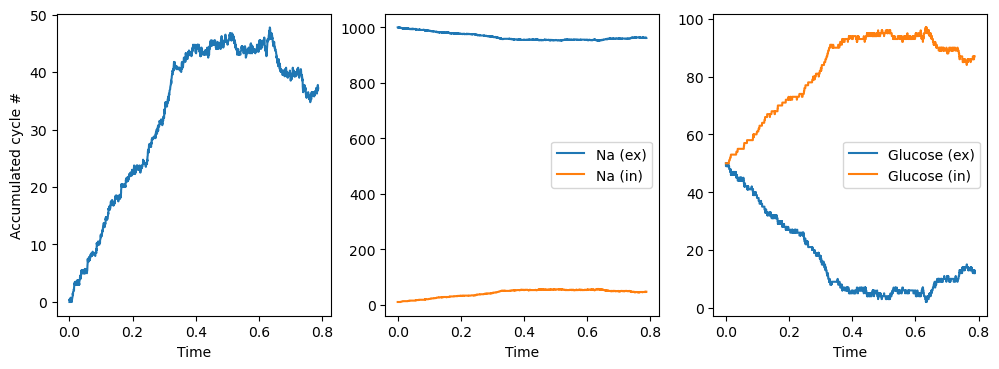

In [3]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

stepN = 2000

k0 = 1000
k = 1

# 初期粒子数
Na0, Na1, Gl0, Gl1 = [0]*stepN, [0]*stepN, [0]*stepN, [0]*stepN
Na0[0], Na1[0] = 1000, 10 # 0 が膜の外側．1が膜の外が内側．
Gl0[0], Gl1[0] = 50, 50

s = [0]*stepN # 積算の状態．s[i]%4 が iステップにおける状態（0..3）に対応する．本書図8.4との対応では，E->0, O-> 1, C -> 2, I -> 3
t = [0]*stepN
for i in range(stepN-1):  
    wf = wb = k0   # wf: 前向き遷移（0->1->2->3->0の方向）の遷移率．wb: 後ろ向き遷移（0->3->2->1->0の方向）の遷移率
    if s[i]%4 == 0:
        wf = k*Na0[i]*Gl0[i]
        wb = k*Na1[i]*Gl1[i]

    Na0[i+1], Na1[i+1], Gl0[i+1], Gl1[i+1] = Na0[i], Na1[i], Gl0[i], Gl1[i]
    
    if wf/(wf + wb) > np.random.rand():
        s[i+1] = s[i] + 1
        if s[i]%4 == 0:
            Na0[i+1] -= 1
            Gl0[i+1] -= 1
        elif s[i]%4 == 3:
            Na1[i+1] += 1
            Gl1[i+1] += 1
    else:
        s[i+1] = s[i] - 1
        if s[i]%4 == 1: 
            Na0[i+1] += 1
            Gl0[i+1] += 1       
        elif s[i]%4 == 0: 
            Na1[i+1] -= 1
            Gl1[i+1] -= 1   
    
    t[i+1] = t[i] -np.log(np.random.rand())/(wf + wb)     # 時間を進める
       
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4), dpi = 100)

ax1.plot(t, np.array(s)/4.0)
ax1.set_xlabel('Time')
ax1.set_ylabel('Accumulated cycle #')

ax2.plot(t, Na0, label = 'Na (ex)')
ax2.plot(t, Na1, label = 'Na (in)')
ax2.legend()
ax2.set_xlabel('Time')

ax3.plot(t, Gl0, label = 'Glucose (ex)')
ax3.plot(t, Gl1, label = 'Glucose (in)')
ax3.legend()
ax3.set_xlabel('Time')

plt.show()

# M2 フラッシングラチェット

8.9節参照．

- のこぎり型ポテンシャルとフラットなポテンシャルをperiodごとに周期的切り替える．
- ランジュバン方程式に従って粒子は運動．

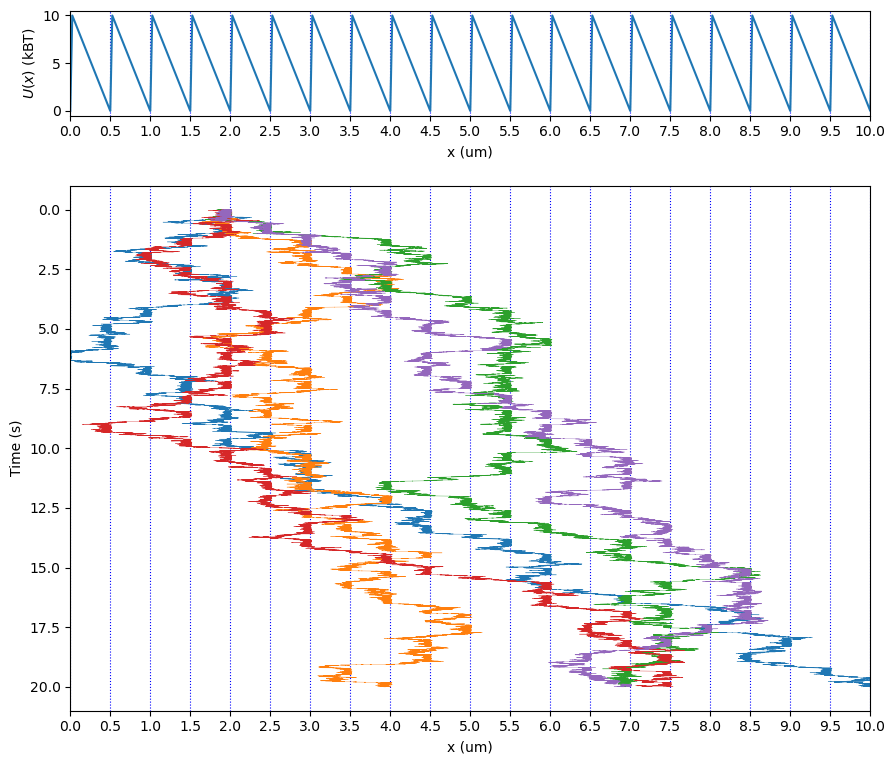

In [497]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)
L = 0.5E-6 # (m)
alpha = 0.05
H = 10*kBT # (kBT)
period = 0.3 # (s)

# パラメータ設定
gamma = 1E-8 # 摩擦係数 (kg/s)
   
T = 20 # (s) 計算時間
dt = 1E-4 # (s) 計算の時間刻み
x0 = 2E-6 # (m) 初期位置．

def U(x):  # のこぎり型ポテンシャル
    xx = x%L
        
    if xx<alpha*L:
        return (H/alpha/L)*xx
    else:
        return H*(1-(xx-alpha*L)/((1-alpha)*L))
    
def dUdx(x):  # のこぎり型ポテンシャルの微分
    xx = x%L   
    
    if xx<alpha*L:
        return H/alpha/L
    else:
        return -H/(1-alpha)/L
    

# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, x0, gamma):  # 時間刻み dt で T だけ計算   
    n = int(T / dt)  # ステップ数
    
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
    r = np.random.standard_normal(size = n - 1) # n-1個の正規乱数（平均0, 分散1）を発生．
       
    x = np.zeros(n)
    x[0] = x0 # m/s, 初期位置
    for i in range(n-1):
        if (i*dt) % (2*period) < period:  # periodごとにのこぎり型ポテンシャルとフラット型ポテンシャルを切り替える．
            f = - dUdx(x[i]) # ポテンシャルからうける力
        else:
            f = 0
            
        x[i + 1] = x[i] + dt * f / gamma + w * r[i]
        
    t = np.linspace(0, T - dt, n)
    return t, x

fig = plt.figure(figsize=(8,7), dpi=100)

ax1 = fig.add_axes([0, 0.85, 1, 0.15], xlabel = 'x (um)', ylabel = r'$U(x)$ (kBT)')

ax1.set_xlim([0, 10])
ax1.grid(axis='x',linestyle='dotted', color='b')
ax1.set_xticks(np.linspace(0,10,21))
ax1.grid

# のこぎり型ポテンシャルを表示
x=[]
u=[]
for i in range(22):
    x.append(i*L*1E6)
    u.append(0)
    x.append((i+alpha)*L*1E6)
    u.append(H/kBT)
ax1.plot(x,u)

ax2 = fig.add_axes([0, 0, 1, 0.75], xlabel = 'x (um)', ylabel = 'Time (s)')

# 同じ計算を5回して重ねてプロット．

for i in range(5):
    t, x = langevin(dt, T, x0, gamma)  # ランジュバン方程式による計算
    ax2.plot(x *1E6, t, lw = 0.25)  # lwは線の太さ．

    
ax2.grid(axis='x',linestyle='dotted', color='b')
ax2.set_xlim([0, 10])
ax2.set_xticks(np.linspace(0,10,21))
ax2.invert_yaxis()

plt.show()

# M3 滞在時間分布

9.3節参照．

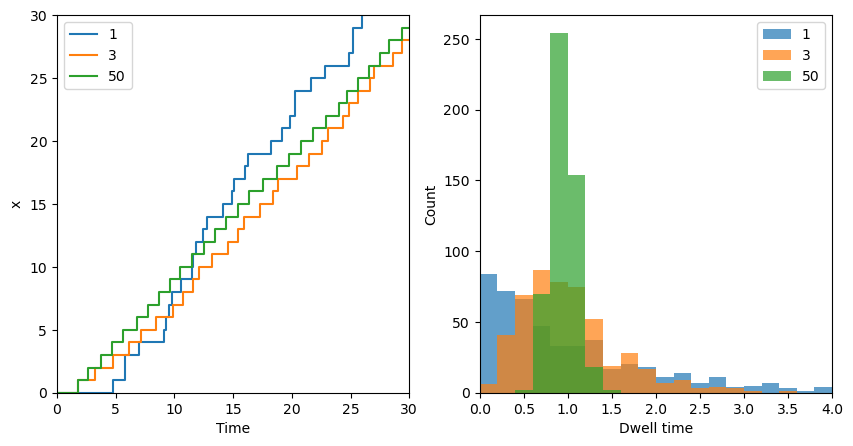

In [39]:
import matplotlib.pyplot as plt
import numpy as np

L = 500         # この距離だけ進んだら修了
tau = 0.001    # 1ステップの時間

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi = 100)

for n in [1,3,50]:    # nは内部状態の数.大きくすると周期的になる．
    w = 1 # 次の場所に移る遷移率
    p = n*w*tau   # 乱数の閾値

    tlist, xlist, duration = [0], [0], []
    
    t=0
    for x in range(L):
        count = 0  # サイコロを振った回数
        for i in range(n):
            while np.random.random() > p:
                count += 1
        t += count*tau

        duration.append(count*tau)

        tlist.append(t)
        xlist.append(x)        
 
    ax1.step(tlist, xlist, where = 'post', label = n) # トラジェクトリをプロット．
    ax2.hist(duration, range = (0, 4), bins = 20, alpha = 0.7, label = n) # ヒストグラムをプロット．

ax1.set_xlabel('Time')
ax1.set_ylabel('x')
ax1.set_xlim([0, 30])
ax1.set_ylim([0, 30])
ax1.legend()

ax2.set_xlabel('Dwell time')
ax2.set_ylabel('Count')
ax2.set_xlim([0,4])
ax2.legend()

plt.show()